# Imports

In [1]:
import os
import os.path as osp

import matplotlib.pyplot as plt
from tqdm import tqdm

import cv2 
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from src.features.segmentation.transformers_dataset import SegmentationDataset

import transformers
import evaluate

# Dataset

In [2]:
# class SegmentationDataset(Dataset):
#     def __init__(
#             self,
#             images_dir: str,
#             masks_dir: str,
#             #image_transform=None,
#             #mask_transform=None,
#             image_processor=None
#     ):
#         super().__init__()
# 
#         self.images_dir = images_dir
#         self.masks_dir = masks_dir
#         #self.image_transform = image_transform
#         #self.mask_transform = mask_transform
#         self.image_processor = image_processor
# 
#         self.images_list = os.listdir(self.images_dir)
#         self.masks_list = os.listdir(self.masks_dir)
# 
#         assert len(self.images_list) == len(self.masks_list), "some images or masks are missing"
#         
#     def __len__(self):
#         return len(self.images_list)
# 
#     def _read_image_and_mask(self, image_name):
#         image = cv2.imread(osp.join(self.images_dir, image_name))
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         mask = cv2.imread(osp.join(self.masks_dir, image_name), cv2.IMREAD_GRAYSCALE)
#         
#         image = torch.from_numpy(image)
#         mask = torch.from_numpy(mask) / 255  # TODO: make normalization
#         
#         return image, mask
# 
#     def __getitem__(self, idx):
#         image, mask = self._read_image_and_mask(self.images_list[idx])
#     
#         encoded_inputs = self.image_processor(image, mask, return_tensors="pt")
#         for k,v in encoded_inputs.items():
#           encoded_inputs[k].squeeze_()
# 
#         return encoded_inputs
#     

In [3]:
train_batch_size = 12
val_batch_size = 4
pin_memory = True
num_workers = 4

In [4]:
train_images_dir = r"C:\Internship\ITMO_ML\data\weakly_segmented\bubbles_split\test\test_images"
train_masks_dir = r"C:\Internship\ITMO_ML\data\weakly_segmented\bubbles_split\test\test_masks"

val_images_dir = r"C:\Internship\ITMO_ML\data\weakly_segmented\bubbles_split\valid\valid_images"
val_masks_dir = r"C:\Internship\ITMO_ML\data\weakly_segmented\bubbles_split\valid\valid_masks"

In [5]:
image_transform = transforms.Compose([
    transforms.Resize((256, 256))
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256))
])

In [6]:
image_processor = transformers.SegformerImageProcessor()

In [7]:
train_dataset = SegmentationDataset(
    images_dir=train_images_dir,
    masks_dir=train_masks_dir,
    #image_transform=image_transform,
    #mask_transform=mask_transform,
    image_processor=image_processor
)

val_dataset = SegmentationDataset(
    images_dir=val_images_dir,
    masks_dir=val_masks_dir,
    #image_transform=image_transform,
    #mask_transform=mask_transform,
    image_processor=image_processor
)

In [8]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 3631
Number of validation examples: 2546


In [9]:
encoded_input = train_dataset[0]
encoded_input["labels"].shape

torch.Size([512, 512])

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, pin_memory=pin_memory, num_workers=num_workers)
valid_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, pin_memory=pin_memory, num_workers=num_workers)

# Model

In [11]:
model = transformers.SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

In [12]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.benchmark = True
model.to(device)

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

In [13]:
metric = evaluate.load("mean_iou")

In [14]:
model.train()
history = {
    "loss": [],
    "mean_iou": [],
    "mean_accuracy": []
}
for epoch in range(2):  # loop over the dataset multiple times
    print("Epoch:", epoch)
    for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
            upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
            predicted = upsampled_logits.argmax(dim=1)

            # note that the metric expects predictions + labels as numpy arrays
            metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

            # let's print loss and metrics every 100 batches
            if idx % 100 == 0:
                metrics = metric._compute(
                    predictions=predicted.cpu(),
                    references=labels.cpu(),
                    num_labels=1,
                    ignore_index=255,
                    reduce_labels=False, # we've already reduced the labels ourselves
                )

                loss_num = loss.item()
                print("Loss:", loss_num)
                history["loss"].append(loss_num)
                print("Mean_iou:", metrics["mean_iou"])
                history["mean_iou"].append(metrics["mean_iou"])
                print("Mean accuracy:", metrics["mean_accuracy"])
                history["mean_accuracy"].append(metrics["mean_accuracy"])

Epoch: 0


  0%|          | 1/303 [00:27<2:19:50, 27.78s/it]

Loss: 2.6323225498199463
Mean_iou: 0.42982669593642486
Mean accuracy: 0.45526368496706665


 33%|███▎      | 101/303 [16:22<32:25,  9.63s/it]

Loss: 0.2873087227344513
Mean_iou: 0.8704785676974692
Mean accuracy: 0.9472922397250083


 66%|██████▋   | 201/303 [32:43<16:52,  9.93s/it]

Loss: 0.26399263739585876
Mean_iou: 0.8735656112639045
Mean accuracy: 0.9544945626529642


 99%|█████████▉| 301/303 [48:47<00:19,  9.97s/it]

Loss: 0.2567286193370819
Mean_iou: 0.8743072343705057
Mean accuracy: 0.9472833525769077


100%|██████████| 303/303 [49:07<00:00,  9.73s/it]


Epoch: 1


  0%|          | 1/303 [00:21<1:49:52, 21.83s/it]

Loss: 0.2339216023683548
Mean_iou: 0.8864328503849768
Mean accuracy: 0.9680111755081447


 33%|███▎      | 101/303 [15:54<31:08,  9.25s/it]

Loss: 0.22518138587474823
Mean_iou: 0.8916975355306924
Mean accuracy: 0.962060111552385


 66%|██████▋   | 201/303 [31:25<15:56,  9.38s/it]

Loss: 0.22475014626979828
Mean_iou: 0.8873539513829195
Mean accuracy: 0.9648364511286882


 99%|█████████▉| 301/303 [47:01<00:18,  9.32s/it]

Loss: 0.2148381620645523
Mean_iou: 0.8965473828615089
Mean accuracy: 0.9657871374601811


100%|██████████| 303/303 [47:17<00:00,  9.37s/it]


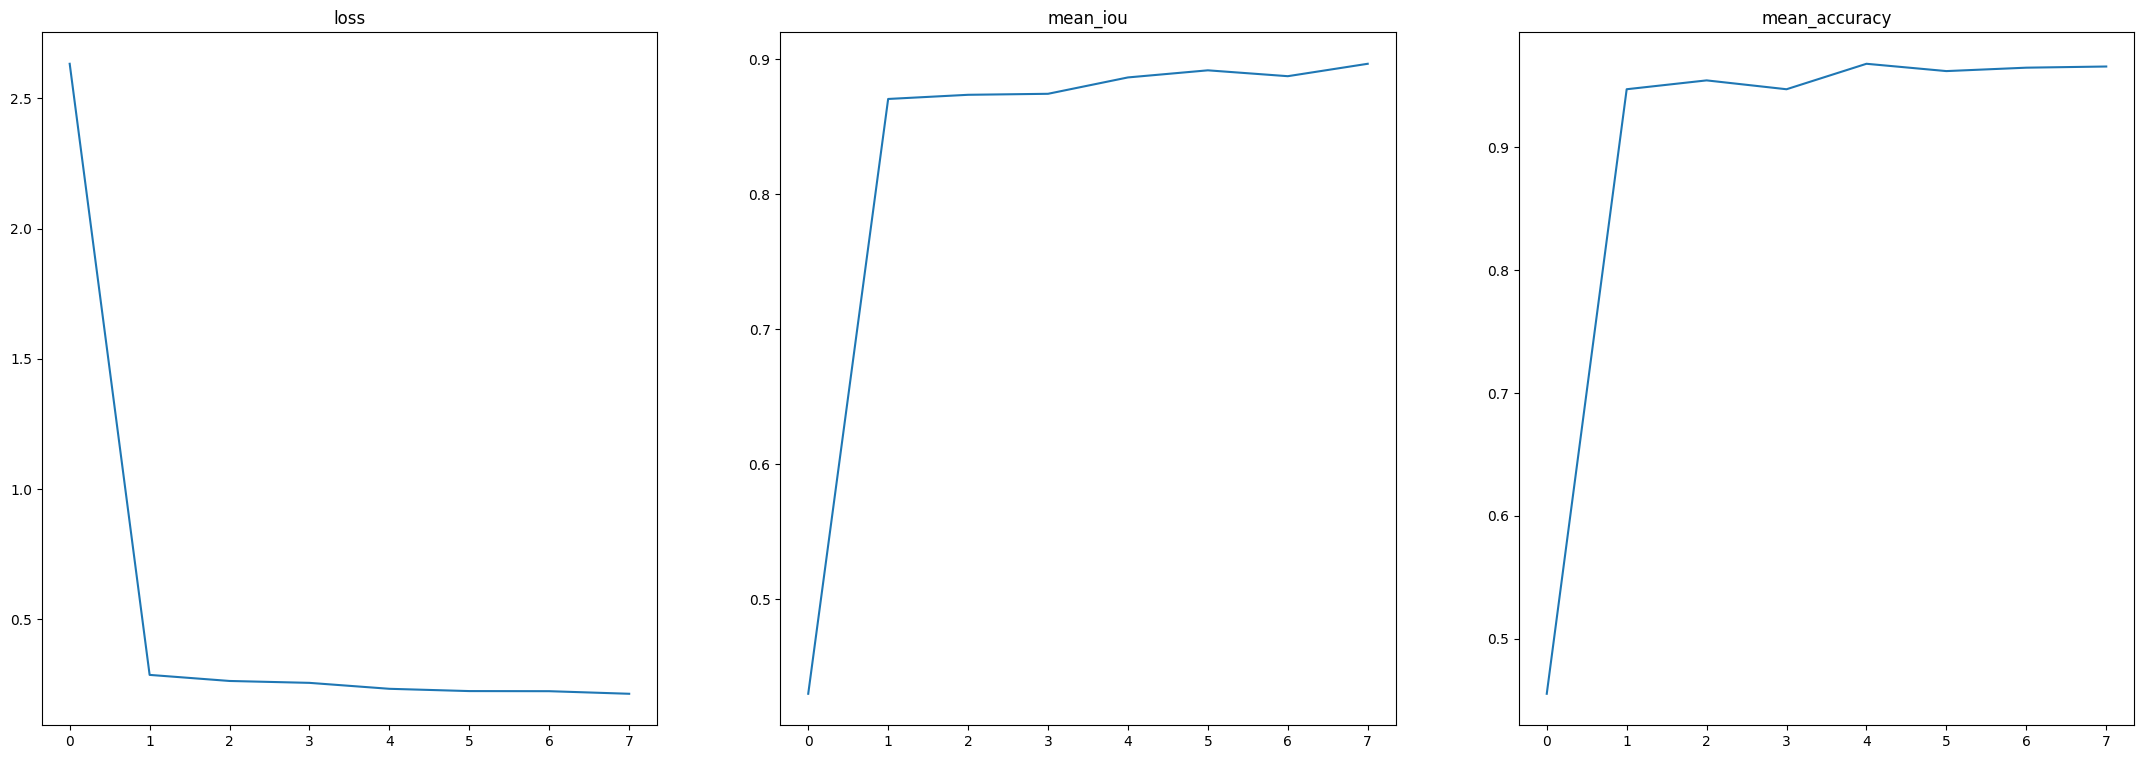

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(27, 9))

ax[0].plot(range(len(history["loss"])), history["loss"])
ax[0].set_title("loss")
ax[1].plot(range(len(history["mean_iou"])), history["mean_iou"])
ax[1].set_title("mean_iou")
ax[2].plot(range(len(history["mean_accuracy"])), history["mean_accuracy"])
ax[2].set_title("mean_accuracy")
plt.show()

In [16]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

In [24]:
save_model(model, path=r"C:\Internship\ITMO_ML\CTCI\checkpoints\segformer\segformer_test\run1\weights_epoch2.pt")

# Results

In [41]:
from PIL import Image

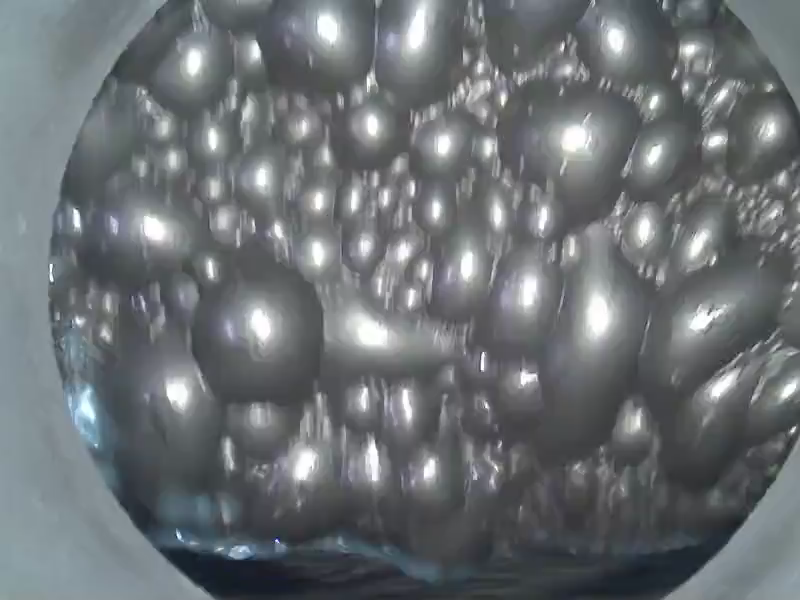

In [42]:
image = Image.open(r"C:\Internship\ITMO_ML\CTCI\data\frame-0.png")
image

In [43]:
pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [44]:
with torch.no_grad():
  outputs = model(pixel_values=pixel_values)

In [45]:
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 150, 128, 128])


In [46]:
predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()
print(predicted_segmentation_map)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


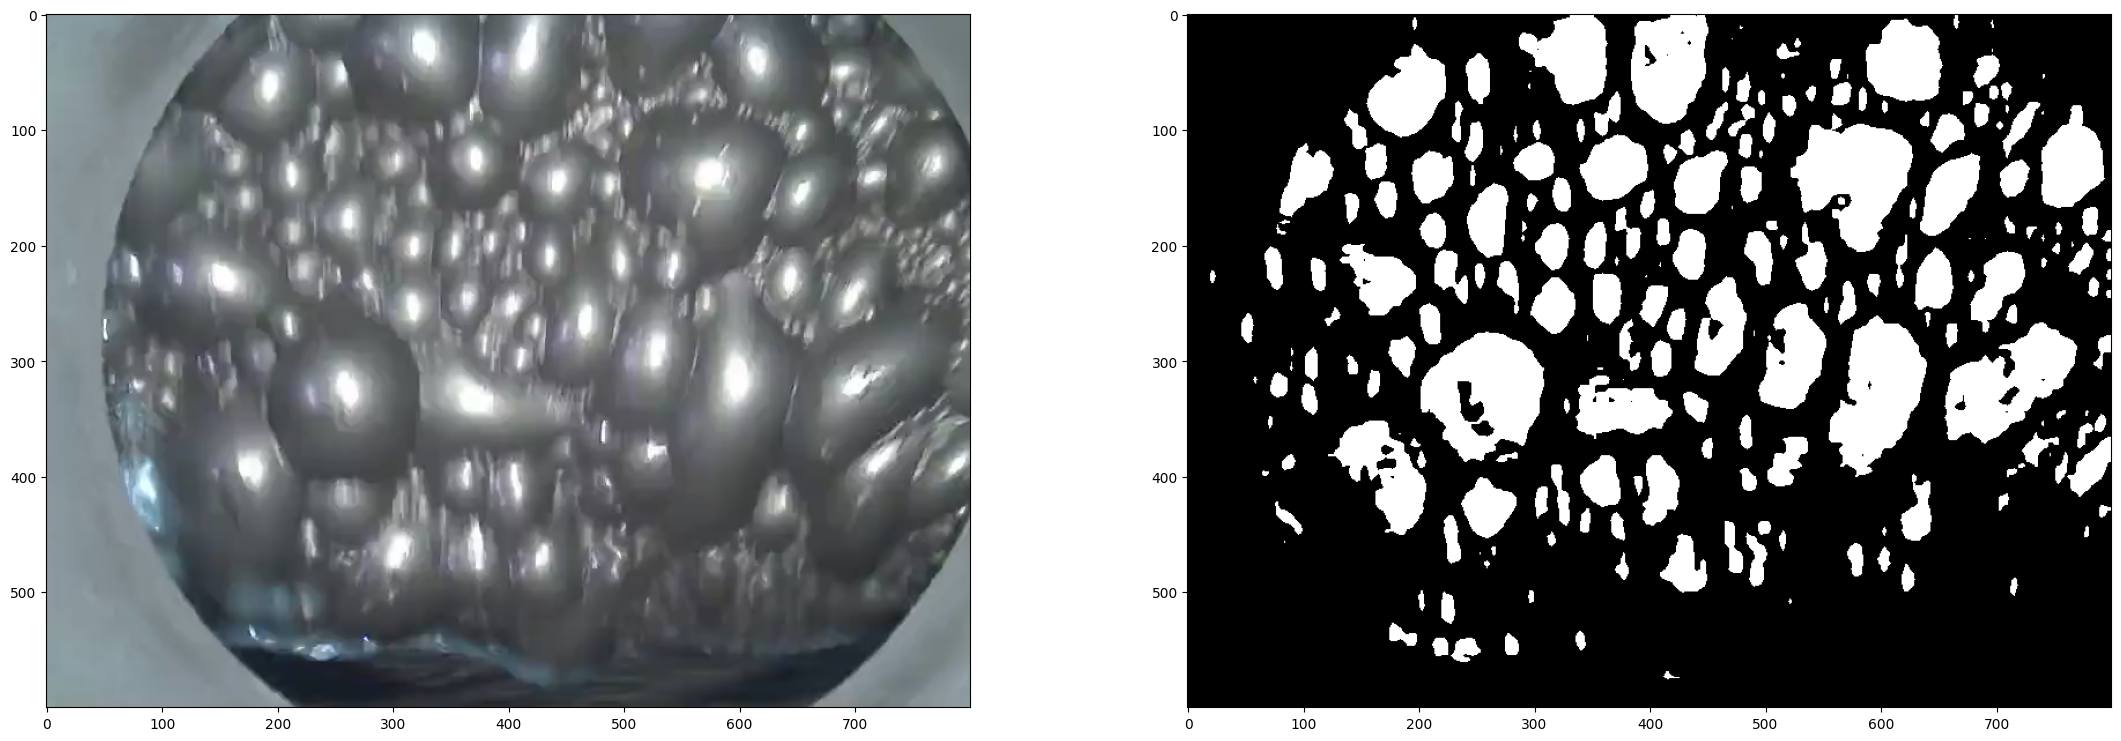

In [47]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(27, 9))

ax[0].imshow(image)
ax[1].imshow(predicted_segmentation_map, cmap="gray")
plt.show()